
## 1. Setup Environment: 

Ensure the necessary packages, such as PyTorch, and MedMNIST, are installed in your Python environment. If you will be working on multiple deep learning projects at the same time, I highly recommend using PyPI (only for Python packages) or Anaconda (for managing Python, Java, C++, etc. packages) to manage the dependencies.
Hint: To install MedMNIST, please refer to the documentation:
https://medmnist.com/Links to an external site.
Links to an external site.https://github.com/MedMNIST/MedMNISTLinks to an external site.
 


In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install medmnist matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121
ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 46.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models

from medmnist import INFO
from medmnist import PathMNIST 

from sklearn.metrics import accuracy_score, roc_auc_score


## 2. Load and Preprocess the MedMNIST Dataset:

Choose one of the twelve datasets from MedMNIST2D for the experiments.
Use the MedMNIST dataset API to download and load the dataset of your choice (e.g., PathMNIST, DermaMNIST, or OrganMNIST).
Normalize the dataset and create data loaders for the training and testing sets.
(Optional) Implement data augmentation techniques to improve generalization.
Hint: Refer to the MedMNIST repository documentation for preprocessing steps: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynbLinks to an external site.
 


In [9]:
from medmnist import INFO, PathMNIST

data = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']          
n_channels = info['n_channels']
n_classes = len(info['label'])

print(info)
print("Task:", task)
print("Channels:", n_channels, "Num classes:", n_classes)


{'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1', 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616', 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1', 'MD5_128': 

In [10]:
image_size = 64  # 28, 64

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # simple normalization around 0.5; can tune if you want
    transforms.Normalize(mean=[0.5]*n_channels, std=[0.5]*n_channels)
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*n_channels, std=[0.5]*n_channels)
])

train_dataset = PathMNIST(split='train', transform=train_transform, download=download)
val_dataset   = PathMNIST(split='val',   transform=test_transform,  download=download)
test_dataset  = PathMNIST(split='test',  transform=test_transform,  download=download)

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


train_labels = train_dataset.labels.squeeze()
unique, counts = np.unique(train_labels, return_counts=True)
for c, cnt in zip(unique, counts):
    print(f"class {c}: {cnt} samples")

batch_size = 128
num_workers = 2  # set 0 if issues

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers)

dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

Train: 89996 Val: 10004 Test: 7180
class 0: 9366 samples
class 1: 9509 samples
class 2: 10360 samples
class 3: 10401 samples
class 4: 8006 samples
class 5: 12182 samples
class 6: 7886 samples
class 7: 9401 samples
class 8: 12885 samples


## 3. Construct the Neural Network Architecture:

Choose one the classical CNNs (e.g. AlexNet, VGG16, GoogLeNet, ResNet) for the experiments.
Define the model in PyTorch, specifying layers, activation functions, and the forward pass.
(Optional) Adjust the architecture of NN for a better performance.
Hint: Example code for implementation CNNs in PyTorch can be found here: https://d2l.ai/chapter_convolutional-modern/index.html (Adapt this for MedMNIST)
 

In [11]:
def build_resnet18(n_channels, n_classes, pretrained=False):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

    if n_channels != 3:
        old_conv = model.conv1
        model.conv1 = nn.Conv2d(
            n_channels, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None
        )

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, n_classes)

    return model
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_resnet18(n_channels=n_channels, n_classes=n_classes, pretrained=False)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Define Loss Function and Optimizer:

Select an appropriate loss function for the classification task (e.g., cross-entropy loss).
Choose an optimizer like Adam or SGD and set its initial learning rate.
Hint: You can try different loss functions and optimizers with various hyperparameters (learning rate, momentum, etc.) to improve performance.
 

In [12]:
base_config = {
    "lr": 1e-3,
    "batch_size": 128,
    "epochs": 10,
    "optimizer": "adam",   # or "sgd"
    "weight_decay": 1e-4,
    "use_scheduler": True,
}

def create_optimizer_and_scheduler(model, config):
    if config["optimizer"].lower() == "adam":
        optimizer = optim.Adam(
            model.parameters(),
            lr=config["lr"],
            weight_decay=config["weight_decay"]
        )
    else:
        optimizer = optim.SGD(
            model.parameters(),
            lr=config["lr"],
            momentum=0.9,
            weight_decay=config["weight_decay"]
        )

    if config.get("use_scheduler", False):
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    else:
        scheduler = None

    criterion = nn.CrossEntropyLoss()
    return criterion, optimizer, scheduler


## 5. Train the Model:

Implement the training loop, ensuring you track the loss and accuracy as the model trains.
 



In [13]:
def train_model(model, dataloaders, dataset_sizes, config, num_epochs=10, patience=3):
    since = time.time()
    criterion, optimizer, scheduler = create_optimizer_and_scheduler(model, config)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    epochs_no_improve = 0

    hist = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 15)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.squeeze().long().to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == targets.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]

            hist[f"{phase}_loss"].append(epoch_loss)
            hist[f"{phase}_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy model
            if phase == "val":
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if scheduler is not None:
            scheduler.step()

        # early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.1f}m. Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, hist
    
config = base_config.copy()
num_epochs = config["epochs"]

model = build_resnet18(n_channels, n_classes, pretrained=False).to(device)
best_model, history = train_model(model, dataloaders, dataset_sizes, config, num_epochs=num_epochs)

Epoch 1/10
---------------
train Loss: 0.5640 Acc: 0.7961
val Loss: 0.6281 Acc: 0.7683

Epoch 2/10
---------------
train Loss: 0.3108 Acc: 0.8904
val Loss: 0.9580 Acc: 0.7566

Epoch 3/10
---------------
train Loss: 0.2436 Acc: 0.9148
val Loss: 0.6592 Acc: 0.8355

Epoch 4/10
---------------
train Loss: 0.2044 Acc: 0.9298
val Loss: 0.4338 Acc: 0.8590

Epoch 5/10
---------------
train Loss: 0.1739 Acc: 0.9391
val Loss: 1.3897 Acc: 0.7134

Epoch 6/10
---------------
train Loss: 0.0877 Acc: 0.9700
val Loss: 0.1027 Acc: 0.9652

Epoch 7/10
---------------
train Loss: 0.0690 Acc: 0.9760
val Loss: 0.0852 Acc: 0.9725

Epoch 8/10
---------------
train Loss: 0.0599 Acc: 0.9789
val Loss: 0.1242 Acc: 0.9608

Epoch 9/10
---------------
train Loss: 0.0510 Acc: 0.9827
val Loss: 0.0970 Acc: 0.9678

Epoch 10/10
---------------
train Loss: 0.0455 Acc: 0.9845
val Loss: 0.1143 Acc: 0.9651
Early stopping at epoch 10
Training complete in 131.0m. Best val Acc: 0.9725


In [20]:
# save the model
torch.save(best_model.state_dict(), "pathmnist_resnet18_best.pth")

## 6. Evaluate the Model:

After training, evaluate the model's performance on the test dataset.
 



In [14]:
def evaluate_on_loader(model, loader):
    model.eval()
    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_targets.append(targets.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)

    acc = accuracy_score(all_targets, all_preds)

    # multi-class macro AUC
    try:
        auc = roc_auc_score(all_targets, all_probs, multi_class="ovr")
    except ValueError:
        auc = None

    return acc, auc, all_targets, all_preds, all_probs

test_acc, test_auc, y_true, y_pred, y_prob = evaluate_on_loader(best_model, test_loader)
print("Test accuracy:", test_acc)
print("Test AUC:", test_auc)

Test accuracy: 0.8430362116991643
Test AUC: 0.9750468224961123


## 7. Tune Hyperparameters:

Experiment with different hyperparameters, including learning rate, batch size, number of epochs, and any regularization techniques.
Use techniques like learning rate scheduling and early stopping to improve performance.
 



In [21]:
#load the trained model
model = build_resnet18(n_channels, n_classes, pretrained=False).to(device)
state_dict = torch.load("pathmnist_resnet18_best.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
import numpy as np
from torch.utils.data import Subset

experiments = []

# create a fixed subset of the training data for all tuning runs
subset_frac = 0.2  # e.g., use 20% of training data
subset_size = int(len(train_dataset) * subset_frac)
subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = Subset(train_dataset, subset_indices)

def run_experiment(name, config):
    print(f"\n===== Experiment: {name} =====")

    train_dataset.transform = train_transform  # base transform

    # use the subset for training
    train_loader = DataLoader(
        train_subset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=num_workers,
    )
    dataloaders = {"train": train_loader, "val": val_loader}
    dataset_sizes = {"train": len(train_subset), "val": len(val_dataset)}

    model = build_resnet18(n_channels, n_classes, pretrained=False).to(device)

    best_model, hist = train_model(
        model,
        dataloaders,
        dataset_sizes,
        config,
        num_epochs=config["epochs"],  # you can keep 3 here if you want
        patience=2,
    )

    val_acc = max(hist["val_acc"])

    experiments.append({
        "name": name,
        "config": config.copy(),
        "val_acc": val_acc,
        "history": hist,
    })

    print(f"[RESULT] {name} | best val_acc={val_acc:.4f}")
    return best_model, hist

# Hyperparameter grid: optimizer, lr, batch size (total of 8 combinations)
for opt in ["adam", "sgd"]:
    if opt == "adam":
        lr_list = [1e-3, 3e-3]
    else:  # "sgd"
        lr_list = [1e-2, 3e-2]

    for lr in lr_list:
        for bs in [64, 128]:
            cfg = base_config.copy()
            cfg["optimizer"] = opt
            cfg["lr"] = lr
            cfg["batch_size"] = bs
            cfg["epochs"] = 3  # short runs on the subset

            run_experiment(
                name=f"{opt}_lr={lr}_bs={bs}",
                config=cfg,
            )

# Identify best config
sorted_exps = sorted(experiments, key=lambda exp: exp["val_acc"], reverse=True)
print("\n===== Summary (sorted by val_acc) =====")
for exp in sorted_exps:
    print(exp["name"], "val_acc=", f"{exp['val_acc']:.4f}")

best_exp = sorted_exps[0]
print("\nBest config:", best_exp["name"], "with val_acc=", best_exp["val_acc"])
best_config = best_exp["config"]



===== Experiment: adam_lr=0.001_bs=64 =====
Epoch 1/3
---------------
train Loss: 0.9420 Acc: 0.6535
val Loss: 1.3145 Acc: 0.5744

Epoch 2/3
---------------
train Loss: 0.6643 Acc: 0.7614
val Loss: 1.0826 Acc: 0.6204

Epoch 3/3
---------------
train Loss: 0.5380 Acc: 0.8060
val Loss: 0.4984 Acc: 0.8271

Training complete in 10.6m. Best val Acc: 0.8271
[RESULT] adam_lr=0.001_bs=64 | best val_acc=0.8271

===== Experiment: adam_lr=0.001_bs=128 =====
Epoch 1/3
---------------
train Loss: 0.8757 Acc: 0.6799
val Loss: 0.9089 Acc: 0.6550

Epoch 2/3
---------------
train Loss: 0.5995 Acc: 0.7824
val Loss: 1.3901 Acc: 0.6254

Epoch 3/3
---------------
train Loss: 0.5012 Acc: 0.8188
val Loss: 0.5491 Acc: 0.8052

Training complete in 10.2m. Best val Acc: 0.8052
[RESULT] adam_lr=0.001_bs=128 | best val_acc=0.8052

===== Experiment: adam_lr=0.003_bs=64 =====
Epoch 1/3
---------------
train Loss: 1.1106 Acc: 0.5822
val Loss: 2.4721 Acc: 0.3628

Epoch 2/3
---------------
train Loss: 0.8560 Acc: 0.69

## 8. Visualization and Analysis:

Plot training and validation loss and performances (e.g. accuracy, AUC score, etc.) over epochs. (only for the best hyperparameters)
 



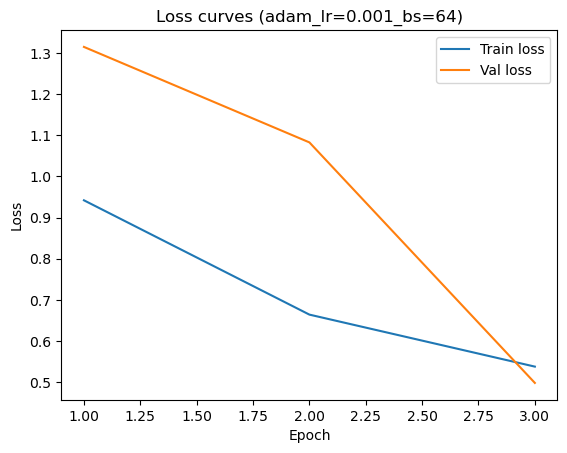

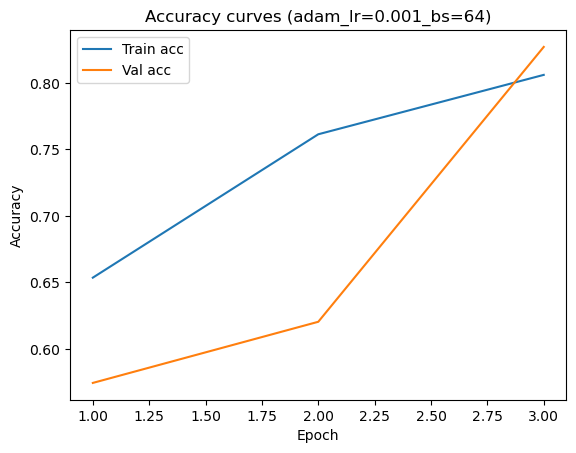

In [28]:
best = sorted_exps[0]
hist = best["history"]

epochs = range(1, len(hist["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, hist["train_loss"], label="Train loss")
plt.plot(epochs, hist["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Loss curves ({best['name']})")
plt.show()

plt.figure()
plt.plot(epochs, hist["train_acc"], label="Train acc")
plt.plot(epochs, hist["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title(f"Accuracy curves ({best['name']})")
plt.show()


In [34]:
# ===== Final training with best hyperparameters =====

# Using best config, but with more epochs
final_config = base_config.copy()
final_config["optimizer"] = best_config["optimizer"]
final_config["lr"] = best_config["lr"]
final_config["batch_size"] = best_config["batch_size"]
final_config["epochs"] = 10  

# Dataloaders for final training (still using train_transform)
train_dataset.transform = train_transform
train_loader = DataLoader(
    train_dataset,
    batch_size=final_config["batch_size"],
    shuffle=True,
    num_workers=num_workers,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=final_config["batch_size"],
    shuffle=False,
    num_workers=num_workers,
)
dataloaders_final = {"train": train_loader, "val": val_loader}
dataset_sizes_final = {"train": len(train_dataset), "val": len(val_dataset)}

# Train final model
final_model = build_resnet18(n_channels, n_classes, pretrained=False).to(device)
best_model, history = train_model(
    final_model,
    dataloaders_final,
    dataset_sizes_final,
    final_config,
    num_epochs=final_config["epochs"],
    patience=3,
)



Epoch 1/10
---------------
train Loss: 0.6032 Acc: 0.7832
val Loss: 0.5954 Acc: 0.7899

Epoch 2/10
---------------
train Loss: 0.3274 Acc: 0.8850
val Loss: 0.4504 Acc: 0.8461

Epoch 3/10
---------------
train Loss: 0.2572 Acc: 0.9106
val Loss: 1.1001 Acc: 0.7540

Epoch 4/10
---------------
train Loss: 0.2143 Acc: 0.9248
val Loss: 1.0299 Acc: 0.7331

Epoch 5/10
---------------
train Loss: 0.1878 Acc: 0.9341
val Loss: 0.2856 Acc: 0.9044

Epoch 6/10
---------------
train Loss: 0.0941 Acc: 0.9678
val Loss: 0.0975 Acc: 0.9664

Epoch 7/10
---------------
train Loss: 0.0736 Acc: 0.9748
val Loss: 0.0825 Acc: 0.9721

Epoch 8/10
---------------
train Loss: 0.0606 Acc: 0.9791
val Loss: 0.0727 Acc: 0.9761

Epoch 9/10
---------------
train Loss: 0.0519 Acc: 0.9824
val Loss: 0.0756 Acc: 0.9750

Epoch 10/10
---------------
train Loss: 0.0426 Acc: 0.9855
val Loss: 0.0761 Acc: 0.9753

Training complete in 146.4m. Best val Acc: 0.9761


In [35]:
from medmnist import PathMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# same normalization you used for train/val
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

test_dataset = PathMNIST(
    split='test',
    download=True,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=final_config["batch_size"],
    shuffle=False,
    num_workers=num_workers,
)


In [ ]:
test_acc, test_auc, y_true, y_pred, y_prob = evaluate_on_loader(best_model, test_loader)
print("\nFinal model performance on test set:")
print("Test accuracy:", test_acc)
print("Test AUC:", test_auc)